# Generating with Character-Level Transformer

In [1]:
import hashlib
import os
import yaml
import scipy.stats
import pandas as pd
import numpy as np
import sys
from multiprocessing import Pool
from IPython.display import clear_output

import torch
from src.model.model import next_char_transformer

In [2]:
run_dir = 'wandb/run-20221110_041703-6926109/files'
seed = 32

checkpoint_path = run_dir + '/final.pt'
with open(run_dir + '/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Load corpus

In [3]:
data_dir = config['root_path']['value']
fn = 'corpus.{}.data'.format(hashlib.md5(data_dir.encode()).hexdigest())
if os.path.exists(fn):
    print('Loading cached dataset...')
    corpus = torch.load(fn)
    ntokens = len(corpus.dictionary)
else:
    print('No precached dataset found')
    raise Exception('No precached dataset found')

Loading cached dataset...


## Load model

In [4]:
# Set the random seed manually for reproducibility.
torch.manual_seed(seed)

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Loading on device: {device}')

Loading on device: cpu


In [5]:
with open(checkpoint_path, 'rb') as f:
    checkpoint = torch.load(f, map_location=device)
model = next_char_transformer(ntokens,
                                n_layers=config['n_layers']['value'],
                                hidden_size=config['hidden_size']['value'],
                                inner_linear=config['inner_linear']['value'],
                                max_sequence_len=config['sequence_length']['value']).to(device)
model.load_state_dict(checkpoint['learner_state_dict'], strict=False)
model.eval()

NextCharTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=128, out_features=128, bias=True)
            (1): Linear(in_features=128, out_features=128, bias=True)
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout): Dropout(p=0.55, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=128, out_features=1024, bias=True)
          (w_2): Linear(in_features=1024, out_features=128, bias=True)
          (dropout): Dropout(p=0.55, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.55, inplace=False)
          )
          (1): S

In [6]:
from src.data.data import subsequent_mask

def generate_with_padding(prompt, temperature=1):
    """ Does greedy generation and incorporates padding in inputted sequence. 
    
    Generates until the end token <END> is reached, or max sequence length reached. """

    seq_len = config['sequence_length']['value']
    masks = subsequent_mask(seq_len)
    sentence = list(prompt)
    sentence_ids = [[corpus.dictionary.word2idx[t]] for t in sentence]
    padding = [[corpus.dictionary.word2idx['<PAD>']]]*(seq_len-len(sentence))

    # Input to model is always length seq_len
    input = torch.tensor(sentence_ids + padding, dtype=torch.long, device=device)

    with torch.no_grad():
        word_idx = 1
        i = len(sentence)-1
        while word_idx != 2 and i < seq_len:
            mask = masks[0][i]
            output = model(input, mask)[-1]
            last_token = output[i][i]
            word_weights = last_token.squeeze().div(temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            word_tensor = torch.Tensor([[word_idx]]).long().to(device)
            input = torch.cat([input[:i+1], word_tensor, input[i+2:]],0)
            sentence.append(corpus.dictionary.idx2word[word_idx])
            i+=1
            print (''.join(sentence))
            
    return sentence
    
# def generate(prompt, temperature=1):
    # """ Does greedy generation. 
    
    # Generates until max sequence length reached. """

    # seq_len = config['sequence_length']['value']
    # sentence = list(prompt)
    # sentence_ids = [[corpus.dictionary.word2idx[t]] for t in sentence]

    # # Input to model is always length seq_len
    # input = torch.tensor(sentence_ids, dtype=torch.long, device=device)

    # with torch.no_grad():
    #     word_idx = 1
    #     i = len(sentence)-1
    #     while word_idx != 2 and i < seq_len:
    #         masks = subsequent_mask(input.size(0))
    #         mask = masks[0][-1]
    #         output = model(input, mask)[-1]
    #         last_token = output[i][i]
    #         word_weights = last_token.squeeze().div(temperature).exp().cpu()
    #         word_idx = torch.multinomial(word_weights, 1)[0]
    #         word_tensor = torch.Tensor([[word_idx]]).long().to(device)
    #         input = torch.cat([input, word_tensor],0)
    #         sentence.append(corpus.dictionary.idx2word[word_idx])
    #         i+=1
    #         print (''.join(sentence))
            
    # return sentence
    
def generate(prompt, temperature=1):
    """ Does greedy generation. 
    
    Generates until max sequence length reached. """

    seq_len = config['sequence_length']['value']
    sentence = list(prompt)
    sentence_ids = [corpus.dictionary.word2idx[t] for t in sentence]

    # Input to model is always length seq_len
    input = torch.LongTensor([sentence_ids], device=device)

    with torch.no_grad():
        word_idx = 1
        i = len(sentence)-1
        while word_idx != 2 and i < seq_len:
            mask = torch.ones(1, 1, input.size(1))
            output = model(input, mask)[-1]
            last_token = output[0][i]
            word_weights = last_token.squeeze().div(temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            word_tensor = torch.Tensor([[word_idx]]).long().to(device)
            input = torch.cat([input, word_tensor],1)
            sentence.append(corpus.dictionary.idx2word[word_idx])
            i+=1
            print (''.join(sentence))
            
    return sentence


In [7]:
prompt = ['<START>', '24', '25']
#prompt = "anarchism originated as a term of abuse first used against early working class rad"
prompt = ['<START>', 'l', 'ʊ', 'k']
#prompt = ['<START>', 'j', 'uː']

sentence = generate(prompt, 1)

<START>lʊkw
<START>lʊkwʌ
<START>lʊkwʌt
<START>lʊkwʌt<END>


## Attention Visualisation

In [8]:
import matplotlib.pyplot as plt
import seaborn

Encoder Layer 2


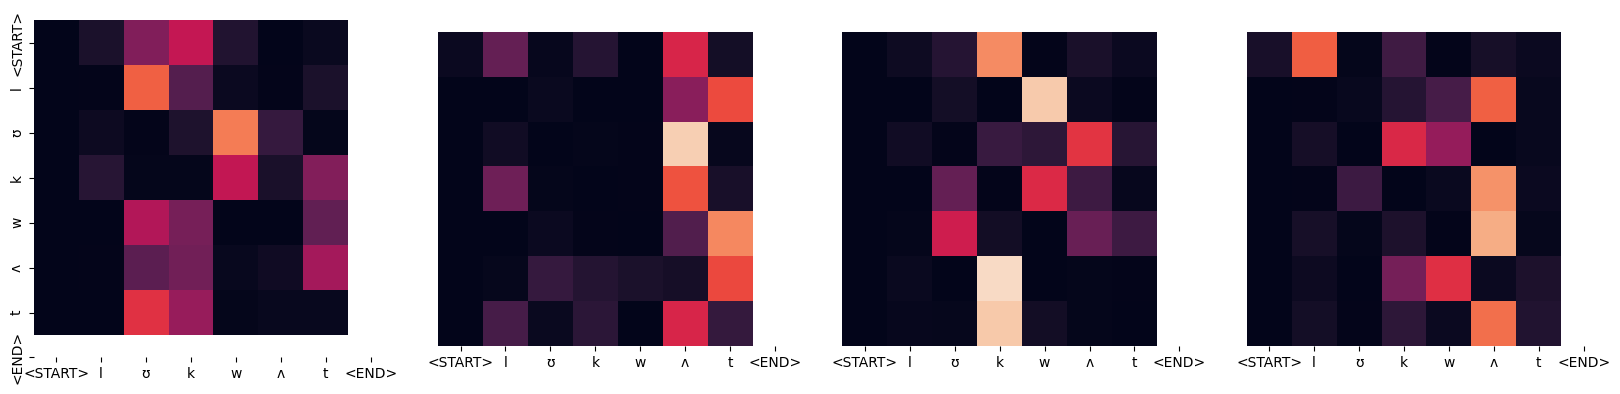

Encoder Layer 4


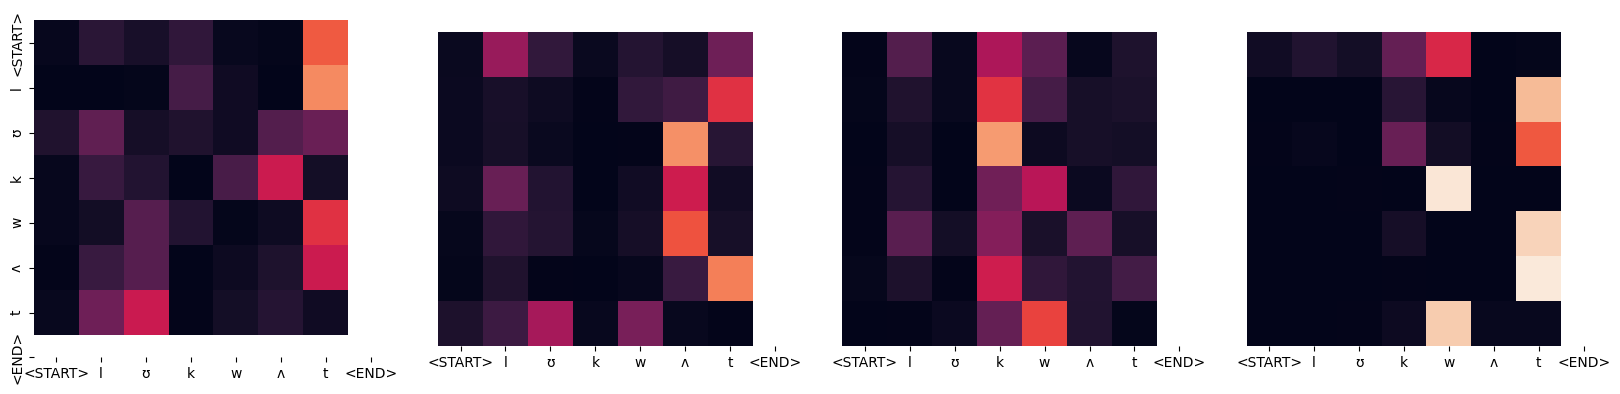

Encoder Layer 6


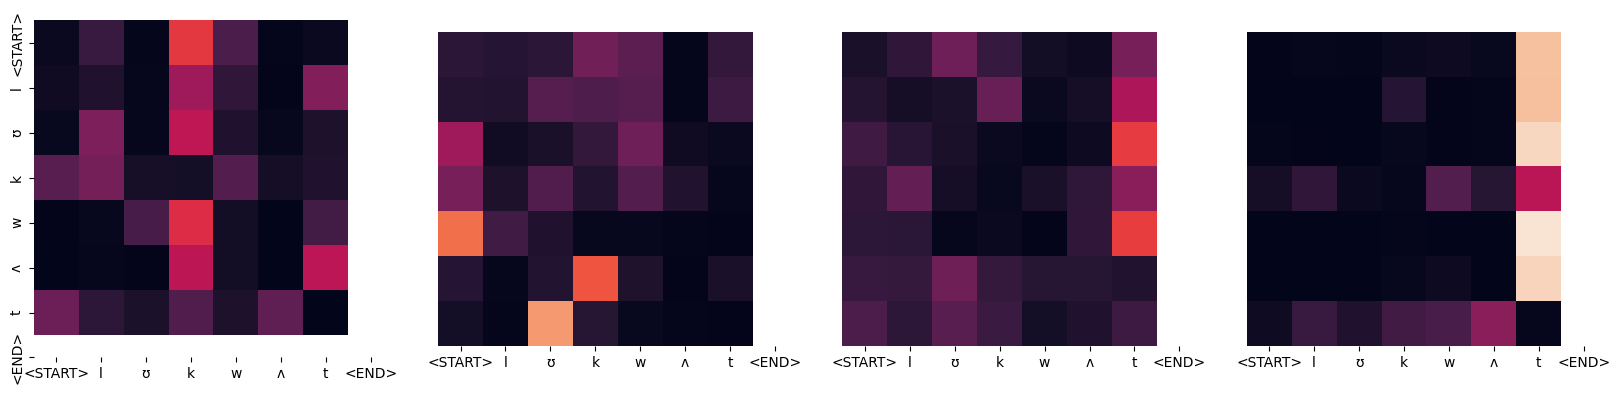

Encoder Layer 8


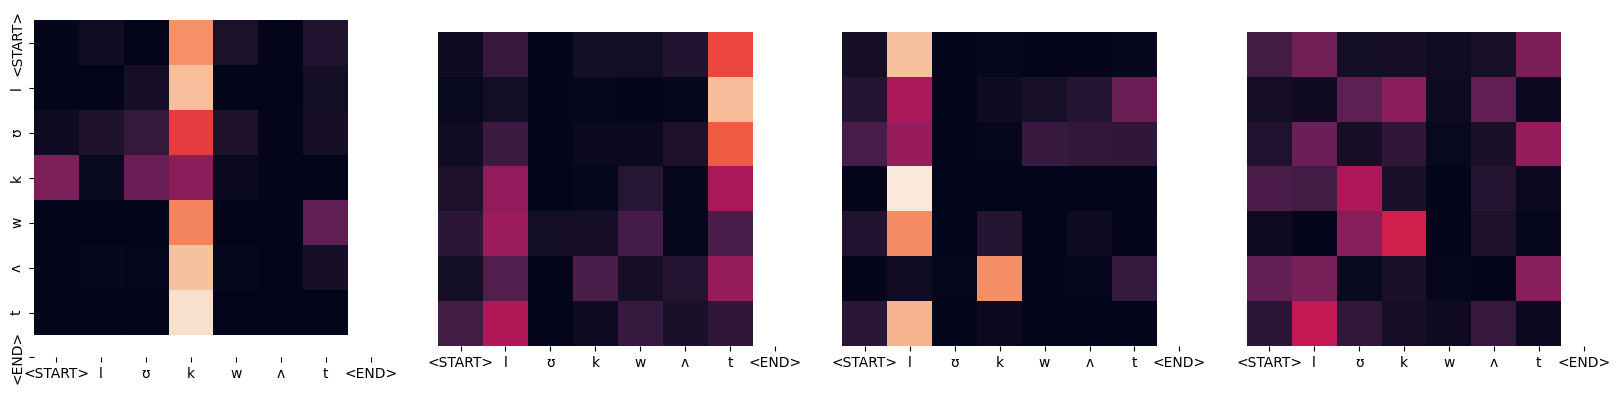

Encoder Layer 10


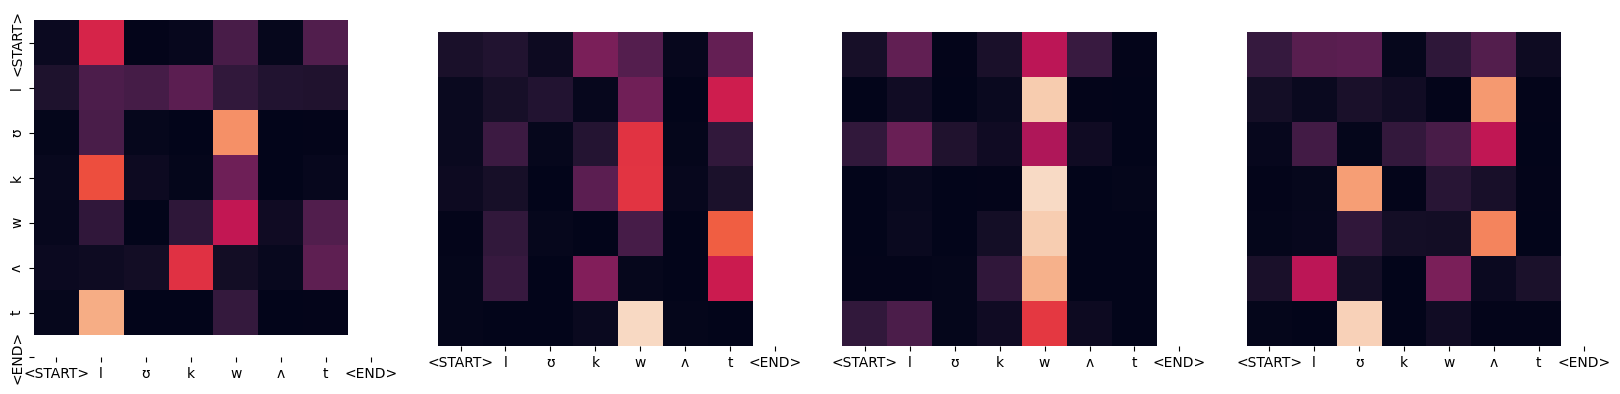

Encoder Layer 12


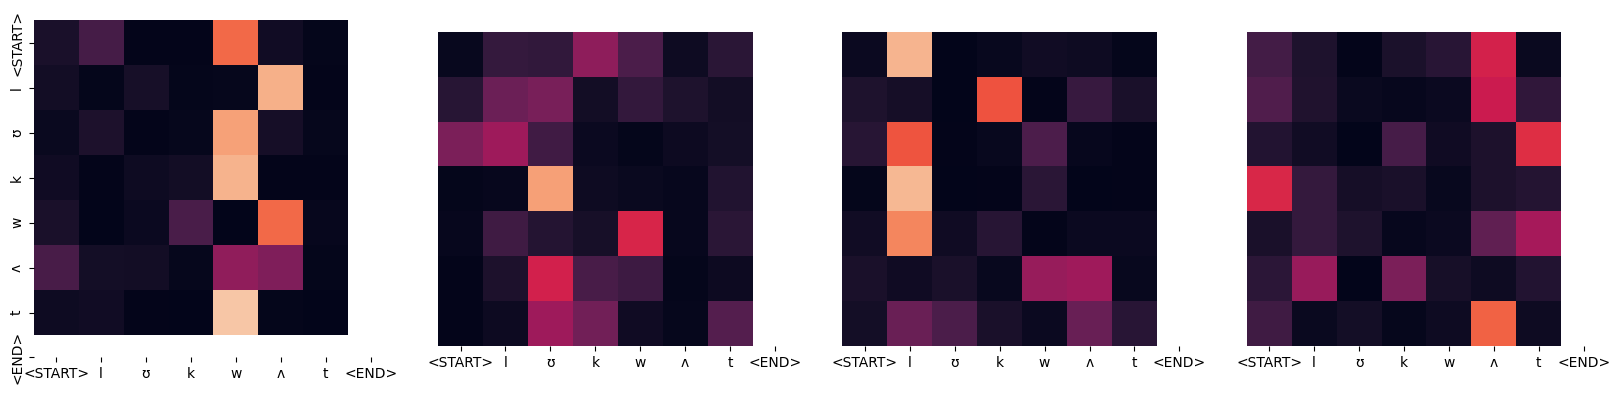

Encoder Layer 14


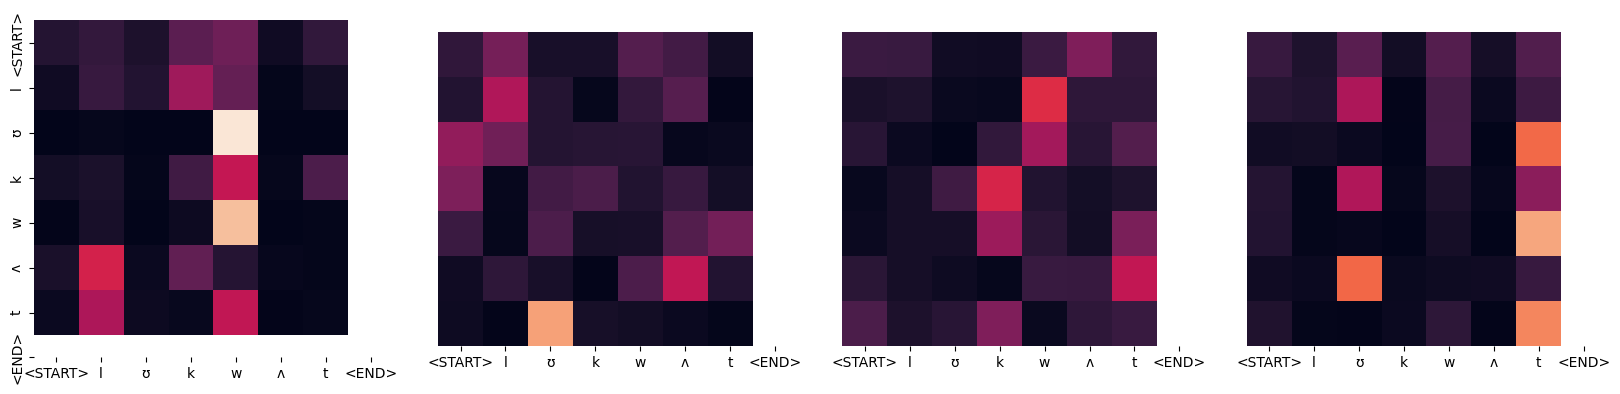

In [9]:
prompt = sentence
#TODO: Should pass in a square mask
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0, vmax=1,
                    cbar=False, ax=ax)
    
for layer in range(1, model.n_layers, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            prompt, prompt if h ==0 else [], ax=axs[h])
    plt.show()


## Prediction Error

Plotting of prediction error from a model given a prompt.

In [10]:
def plot_utterance(data, measures, cutoffs=None):
    """ Plots a single utterance against each measure in `data` to visualise segmentation. 
    Parameters
    ----------
    data : dict
        A processed utterance containing statistical and boundary information. See `process_utterance` method above.
    measures : sequence of str
        List of keys in `data` to plot.
    cutoffs : sequence of str, optional
        Cutoff values used for segmentation, plotted as horizontal lines on each plot.
    """
    _, axs = plt.subplots(len(measures),1, figsize=(20, 10))
    for i, ax in enumerate(axs):
        ax.plot('Pos', measures[i], data=data)
        ax.set_ylabel(measures[i])
        ax.set_xticks(data.Pos, data.Phoneme)
        for j, start in enumerate(data.Starts):
            if start:
                ax.axvline(x=j, color='grey', alpha=0.5)
        if cutoffs:
            ax.axhline(y=cutoffs[i], color='pink', alpha=0.5)
    ax.set_xlabel('Phonemes')
    plt.show()

def print_best_result(results, score):
    best_results = results[results[score] == results[score].max()]
    best_result = float(best_results[score])
    best_cutoff = float(best_results['Cutoff'])
    print('Best cutoff:',best_cutoff)
    print('Best {} at cutoff {}: {}'.format(score, best_cutoff, round(best_result*100, 2)))

def plot_scores_by_cutoff(results):
    """ Plot each measure against the different cutoffs used. Adds a vertical and horizontal line at the best value for each score. """
    num_columns = 3
    scores = sorted(list(set(results.keys()) - {'Cutoff'}))
    num_rows = len(results.keys()) // num_columns
    _, axs = plt.subplots(num_rows, num_columns, figsize=(20, 20))
    column = 0
    for i, score in enumerate(scores):
        graph = seaborn.lineplot(results, x='Cutoff', y=score, ax=axs[i//num_columns, column])
        max_score = results[results[score] == results[score].max()].head(1)
        max_cutoff = float(max_score['Cutoff'])
        max_score = float(max_score[score])
        graph.axvline(max_cutoff, color='grey', alpha=0.5)
        graph.axhline(max_score, color='pink', alpha=0.5)
        graph.set_ybound(0,1)
        column = (column + 1) % num_columns
    plt.show()

def plot_roc(results, measure1, measure2):
    """ Plot two scores against each other (e.g. precision against recall) """
    seaborn.lineplot(results, x=measure1, y=measure2)
    plt.show()

In [11]:
from src.segmentation.segment import Segmenter

segmenter = Segmenter(model, 'data/Eng-NA/test.txt', corpus)

daʊndaʊndaʊn


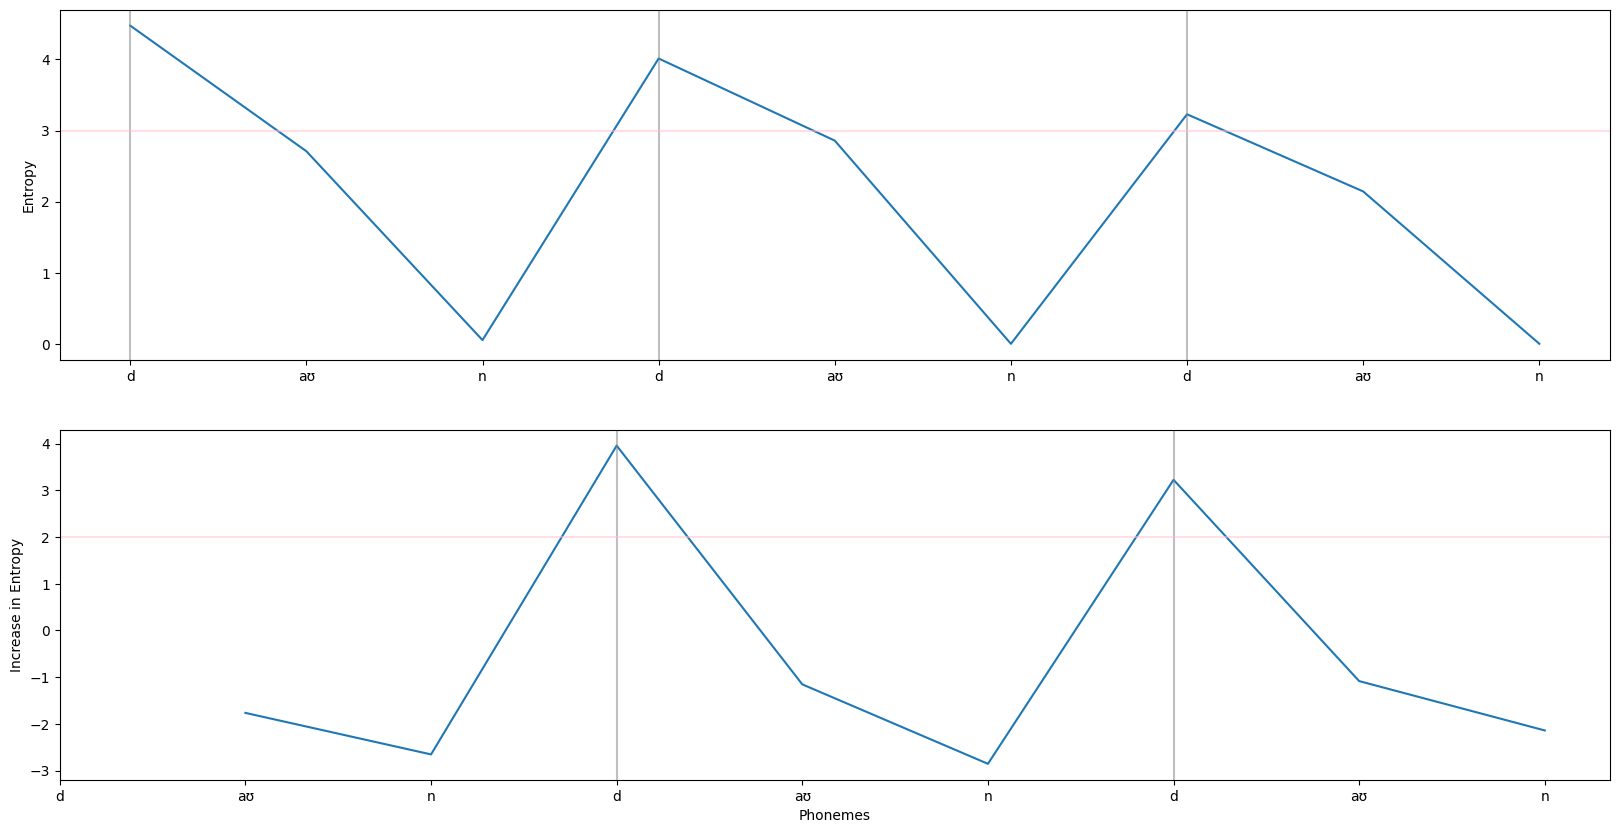

In [ ]:
plot_utterance(segmenter.processed_utterances[21], ['Entropy', 'Increase in Entropy'], [3, 2])
print(''.join(list(segmenter.processed_utterances[21].Phoneme)))

In [ ]:
cutoffs = np.linspace(0,5,51)
entropy_cutoff_data = segmenter.evaluate_cutoff_segmentation('Entropy', cutoffs)
entropy_cutoff_data.head()

Segmenting using cutoff: 5.00


,token_precision,token_recall,token_fscore,type_precision,type_recall,type_fscore,boundary_all_precision,boundary_all_recall,boundary_all_fscore,boundary_noedge_precision,boundary_noedge_recall,boundary_noedge_fscore,Cutoff
0,0.023684,0.071037,0.035524,0.234375,0.003255,0.006420,0.415000,1.000000,0.586572,0.225345,1.000000,0.367806,0.0
1,0.028520,0.081134,0.042204,0.260976,0.023215,0.042638,0.434432,0.999485,0.605626,0.239398,0.998745,0.386220,0.1
2,0.031839,0.088407,0.046818,0.283713,0.035149,0.062548,0.443530,0.999095,0.614337,0.246085,0.997792,0.394800,0.2
3,0.034232,0.093706,0.050145,0.272459,0.040139,0.069970,0.448923,0.998818,0.619437,0.250082,0.997118,0.399873,0.3
4,0.037312,0.100519,0.054423,0.271208,0.045780,0.078337,0.455034,0.998494,0.625167,0.254648,0.996328,0.405624,0.4


Best cutoff: 3.2
Best type_fscore at cutoff 3.2: 27.71


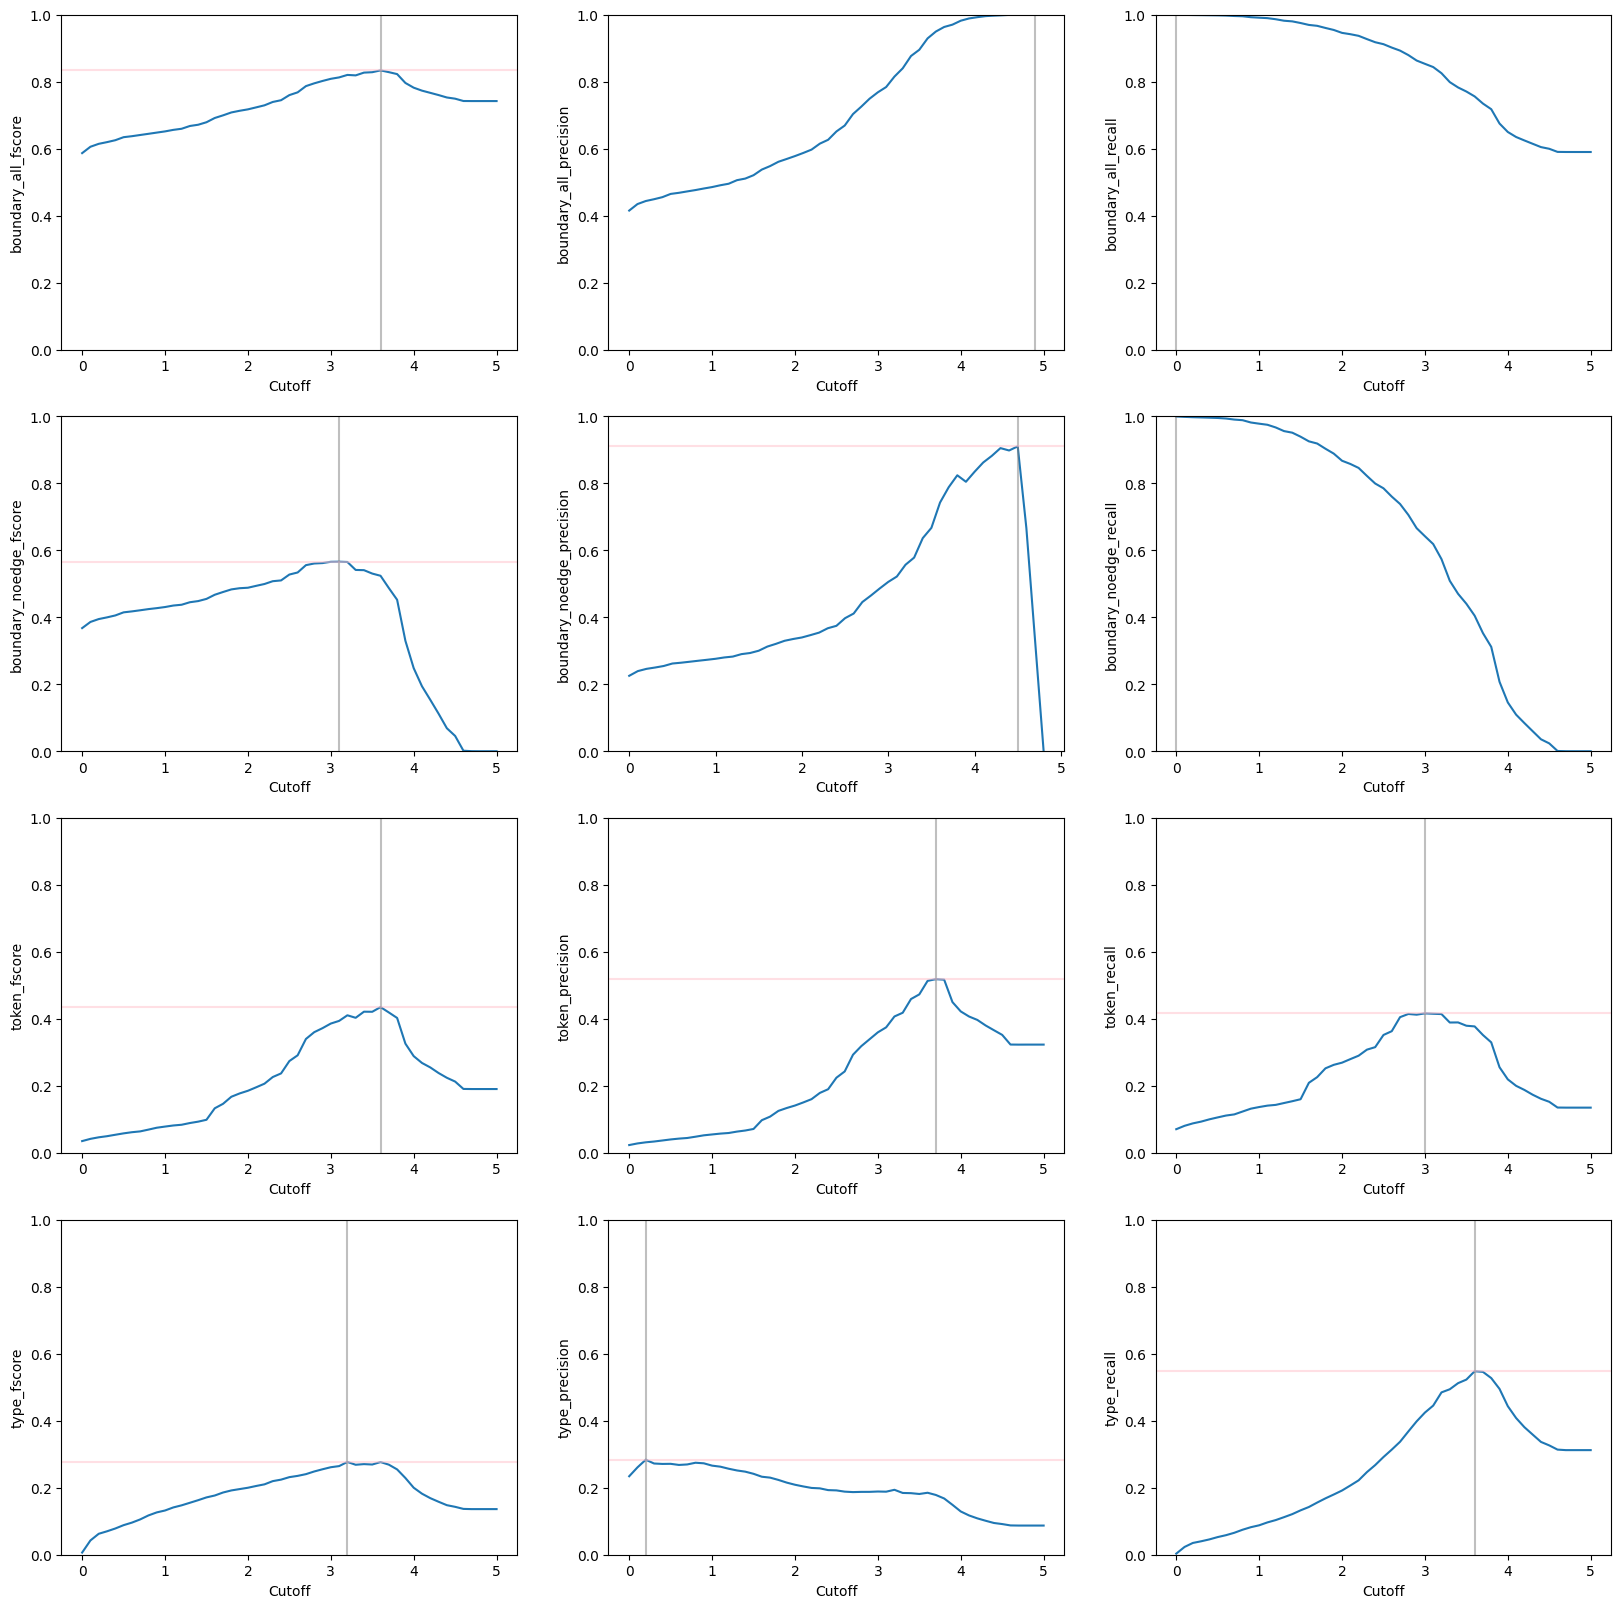

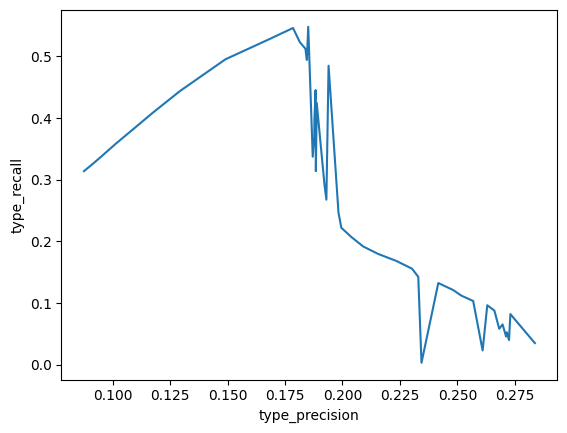

In [ ]:
print_best_result(entropy_cutoff_data, 'type_fscore')
plot_scores_by_cutoff(entropy_cutoff_data)
plot_roc(entropy_cutoff_data[:-4], 'type_precision', 'type_recall')

In [ ]:
cutoffs = np.linspace(0,5,51)
entropy_increase_cutoff_data = segmenter.evaluate_cutoff_segmentation('Increase in Entropy', cutoffs)
entropy_increase_cutoff_data.head()

Segmenting using cutoff: 5.00


,token_precision,token_recall,token_fscore,type_precision,type_recall,type_fscore,boundary_all_precision,boundary_all_recall,boundary_all_fscore,boundary_noedge_precision,boundary_noedge_recall,boundary_noedge_fscore,Cutoff
0,0.386416,0.512220,0.440512,0.235390,0.345194,0.279909,0.743849,0.914587,0.820430,0.507585,0.791707,0.618581,0.0
1,0.401632,0.515559,0.451520,0.232121,0.366891,0.284345,0.756612,0.907926,0.825391,0.521247,0.775461,0.623435,0.1
2,0.424496,0.522615,0.468473,0.225893,0.382729,0.284104,0.774079,0.900225,0.832400,0.541489,0.756682,0.631249,0.2
3,0.437135,0.524549,0.476869,0.222008,0.399653,0.285449,0.784671,0.895298,0.836342,0.554143,0.744666,0.635431,0.3
4,0.453404,0.523575,0.485969,0.216055,0.416359,0.284486,0.798230,0.885329,0.839526,0.568958,0.720355,0.635768,0.4


Best cutoff: 1.2000000000000002
Best type_fscore at cutoff 1.2000000000000002: 28.81


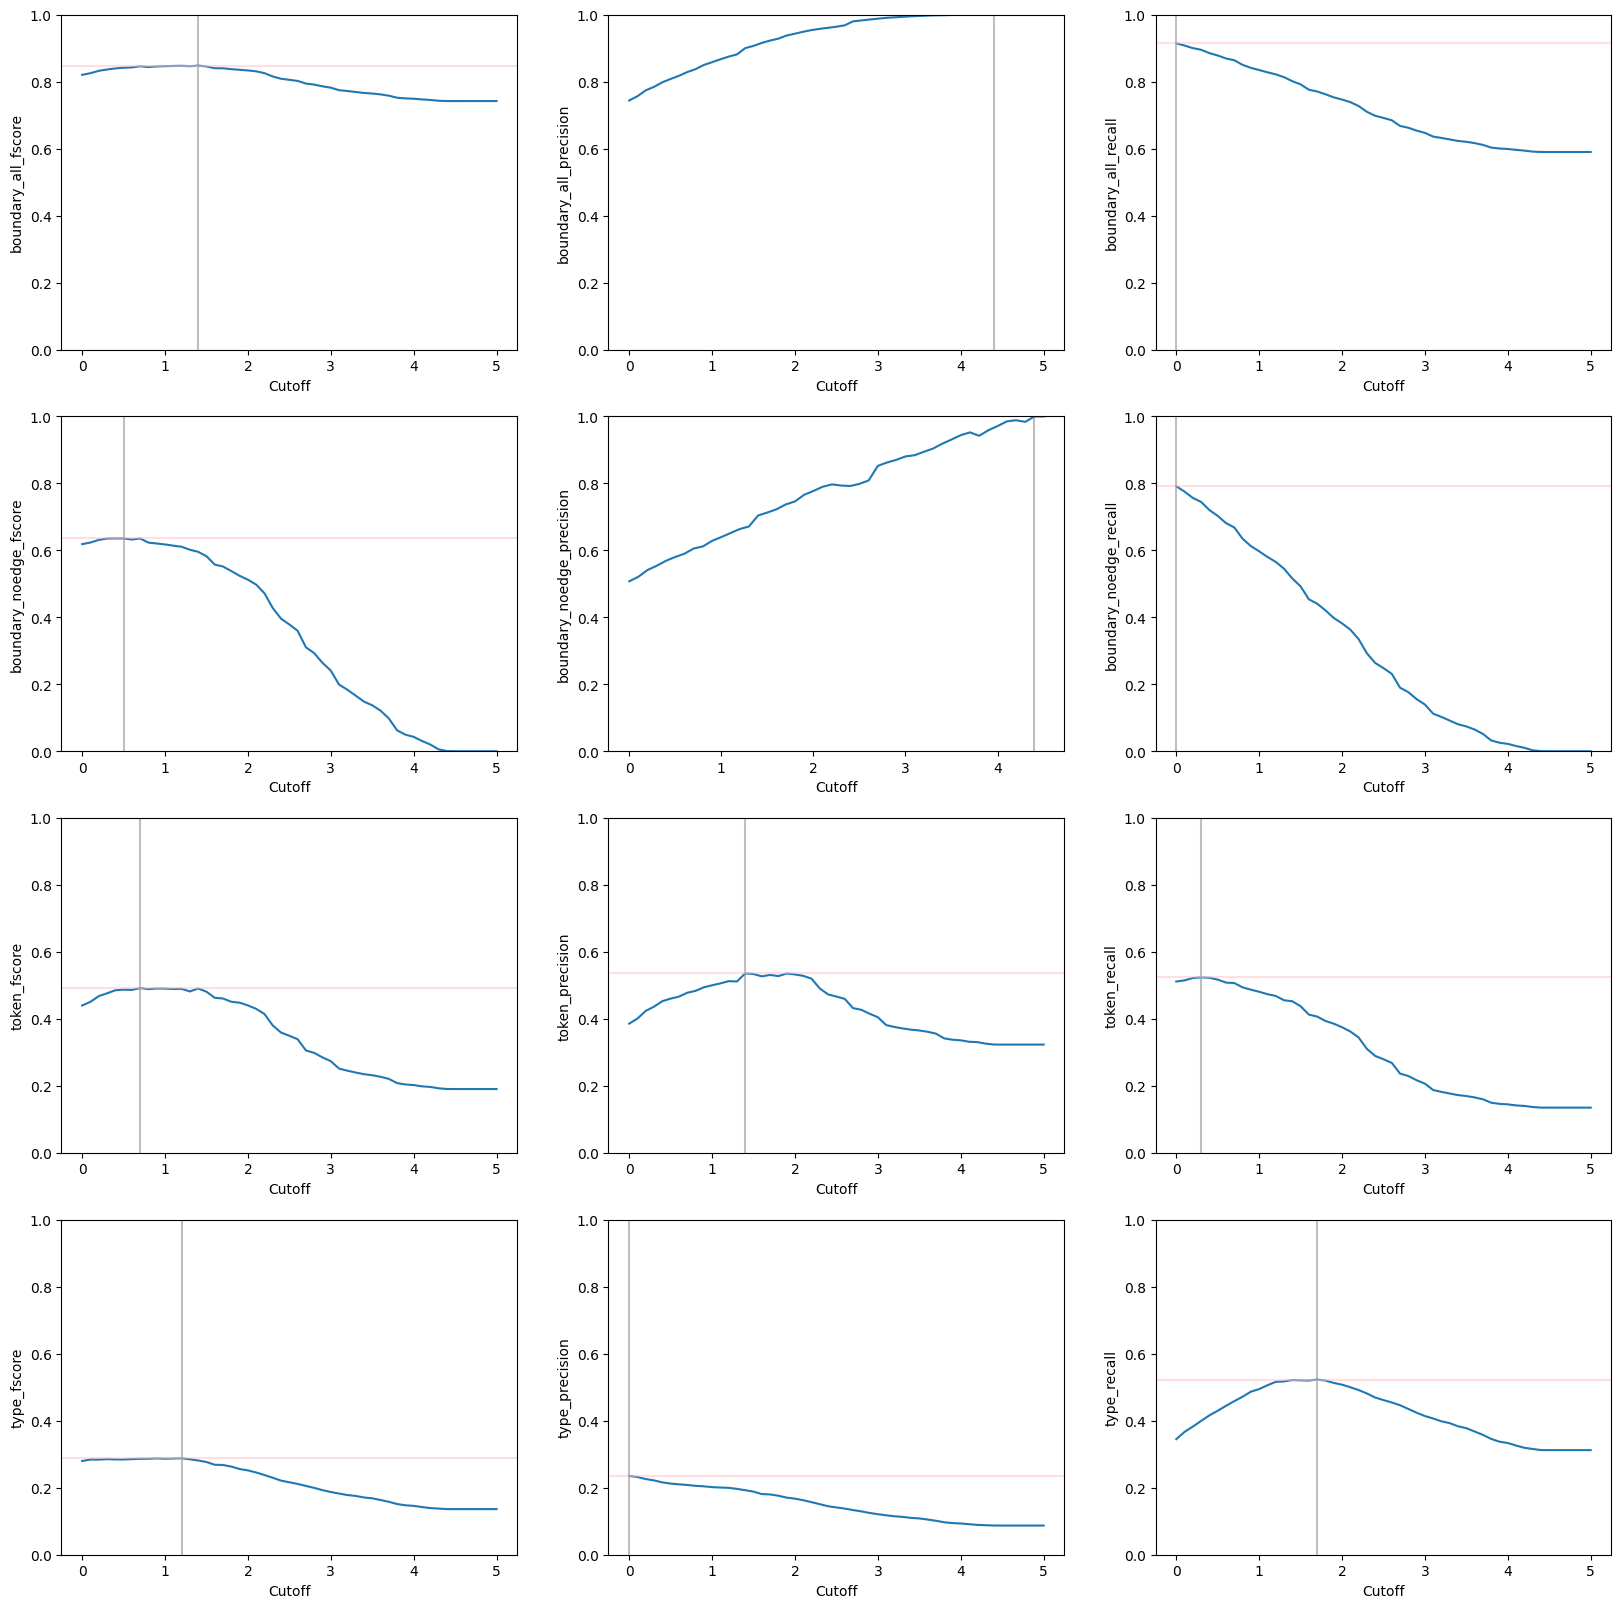

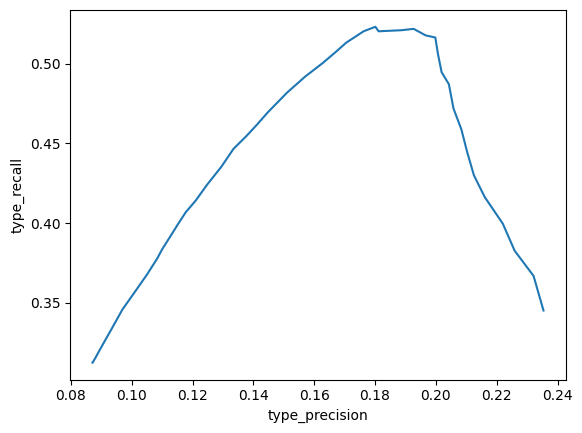

In [ ]:
print_best_result(entropy_increase_cutoff_data, 'type_fscore')
plot_scores_by_cutoff(entropy_increase_cutoff_data)
plot_roc(entropy_increase_cutoff_data[:-4], 'type_precision', 'type_recall')

In [ ]:
entropy_spike_data = segmenter.evaluate_spike_segmentation('Entropy')
print(entropy_spike_data)

OrderedDict([('token_precision', 0.47253650754693827), ('token_recall', 0.5205336866010598), ('token_fscore', 0.4953751945763061), ('type_precision', 0.1944677284157586), ('type_recall', 0.4026903883705793), ('type_fscore', 0.26227654914152476), ('boundary_all_precision', 0.8043223052294557), ('boundary_all_recall', 0.8619217353182242), ('boundary_all_fscore', 0.8321264595198881), ('boundary_noedge_precision', 0.5646616541353383), ('boundary_noedge_recall', 0.6632733695904802), ('boundary_noedge_fscore', 0.6100079088557809)])


In [ ]:
entropy_spike_data = segmenter.evaluate_spike_segmentation('Increase in Entropy')
print(entropy_spike_data)

OrderedDict([('token_precision', 0.46523763648041105), ('token_recall', 0.5483535200605602), ('token_fscore', 0.5033877692842251), ('type_precision', 0.2035828534868842), ('type_recall', 0.3451941852896507), ('type_fscore', 0.25611719253058596), ('boundary_all_precision', 0.7859271046706505), ('boundary_all_recall', 0.8849188952213941), ('boundary_all_fscore', 0.8324905410009504), ('boundary_noedge_precision', 0.5503182674869315), ('boundary_noedge_recall', 0.7193557383907405), ('boundary_noedge_fscore', 0.6235846395615908)])
